# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.322363  0.171273  1.0  0.121398  1.446818  2.491679  2  1  36.115222   
1  0.317601  0.186996  1.0  0.096888  0.738537  0.298177  3  2  30.952930   
2  0.420826 -0.760054  1.0  0.459013  0.970089 -0.092836  2  1  28.523631   
3 -0.147303 -0.720502  1.0  0.848410  0.379322  0.293934  0  0  23.664782   
4 -2.332660 -1.823806  1.0  0.207142  0.405516  0.219034  1  1  21.162110   

            y  
0  430.586986  
1  375.070815  
2  259.508249  
3  168.704956  
4  -70.767731  
True causal estimate is 5.947999202859553


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

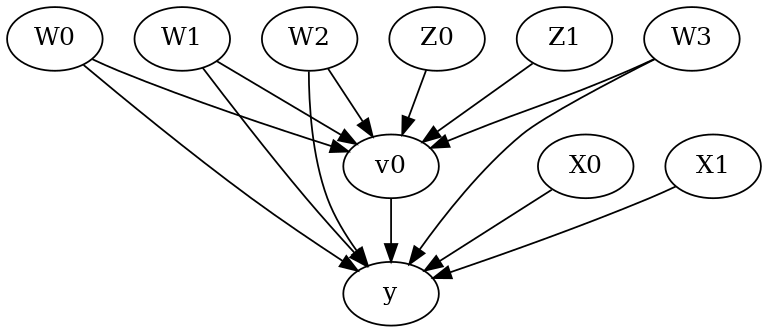

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W3,W1,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W1,W0,U) = P(y|v0,W2,W3,W1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W3,W1,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W1,W0,U) = P(y|v0,W2,W3,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W1+W0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 5.9479955877391735
### Conditional Estimates
__categorical__X1  __categorical__X0
(-4.83, -1.729]    (-4.117, -1.161]     -3.435976
                   (-1.161, -0.574]     -0.564465
                   (-0.574, -0.0757]     1.214385
                   (-0.0757, 0.515]      3.032917
                   (0.515, 3.33]         5.584882
(-1.729, -1.153]   (-4.117, -1.161]     -0.210430
                   (-1.161, -0.574]      2.377434
                   (-0.574, -0.0757]     4.169443
                   (-0.0757, 0.515]      5.796341
                   (0.515, 3.33]  

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W3,W1,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W1,W0,U) = P(y|v0,W2,W3,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W1+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 11.560525126928573
Effect estimates: [ 7.87263352 17.62528572  3.19022403 12.34132948 12.66844009 14.21249907
  3.73933781  8.60215328 19.81838371 15.15764854 11.21204053 16.05932806
 15.54195747 14.58466827  6.87858691 13.83117364  8.41373503 17.2986099
 12.18579024  9.26634126 10.40321106  7.23114201 16.57895304 10.14980381
  5.21776305  2.88266168 16.08462682 10.79187163 10.65653934 13.15876142
 13.70532377 11.23062776 14.25938134 10.670445    9.78929236 15.2279328
 11.86295985 17.54452242 13.67495071 12.34766921 17.20665779  4.084

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 5.947999202859553


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W3,W1,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W1,W0,U) = P(y|v0,W2,W3,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W1+W0 | X1,X0
Target units: 

## Estimate
Mean value: 5.966430567702437
Effect estimates: [11.74253647 11.7814526   8.84006553 ... 13.81779828  9.69609919
 19.46264788]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W3,W1,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W1,W0,U) = P(y|v0,W2,W3,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W1+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 5.945708040620236
Effect estimates: [11.65926775 11.69719161  8.81467036 ... 13.75732328  9.67763878
 19.32249446]
95.0% confidence interval: (array([11.71980612, 11.75852798,  8.86038954, ..., 13.81367257,
        9.71386305, 19.37381635]), array([12.0438754 , 12.08313707,  9.1160675 , ..., 14.29429598,
       10.04404272, 20.06930454]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[12.4682812  12.22740562 15.77886386 15.46346573 13.20595468 11.87712048
 15.23328621 13.35459429 12.99493877 14.38309232]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.834022 -0.355046  1.0  0.688780  0.430682  1.112052 -1.246374   
1    -1.419856  0.184898  1.0  0.638342 -1.994476  1.530221 -0.700790   
2     0.259114  0.316795  1.0  0.104040  0.485408  2.148363 -1.088144   
3    -0.188012 -1.578134  1.0  0.992718 -2.158396  0.470720 -1.526293   
4     0.518895  1.542357  1.0  0.629436 -1.115309  2.154160 -0.153655   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.309609 -0.651789  1.0  0.169806 -0.058166  0.323952 -0.304820   
9996  0.486285  0.752164  1.0  0.537056 -0.983402 -0.302978 -1.362624   
9997 -0.231372  0.671570  1.0  0.283704 -0.717416  2.306253 -1.164600   
9998  0.089101  0.635282  1.0  0.611138 -0.279824 -1.542444 -1.139487   
9999  0.153769  0.959951  1.0  0.564823 -0.053890 -0.652940 -1.797288   

            W3  v0  y  
0    -0.640518   1  1  
1     0.648648   1  1  
2    -1.108927   1  1  
3    -1.434311   1  0  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W3,W1,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W1,W0,U) = P(y|v0,W2,W3,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W1+W0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.4841247708724349
Effect estimates: [0.52915202 0.37040114 0.52118285 ... 0.50108406 0.52612165 0.55139018]

True causal estimate is 0.3722


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-11-16 12:01:21.807650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-11-16 12:01:21.994045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 12:01:21.994076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 12:01:22.020550: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-11-16 12:01:22.725138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-16 12:01:22.725268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-16 12:01:22.725278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-11-16 12:01:23.492376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 12:01:23.492421: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 12:01:23.492446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a39cebcb0fef): /proc/driver/nvidia/version does not exist
2022-11-16 12:01:23.492892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:20 - loss: 215.9843

 34/313 [==>...........................] - ETA: 0s - loss: 55.1348   

 69/313 [=====>........................] - ETA: 0s - loss: 30.6453

104/313 [========>.....................] - ETA: 0s - loss: 22.2936

139/313 [============>.................] - ETA: 0s - loss: 17.9990

174/313 [===============>..............] - ETA: 0s - loss: 15.3592

209/313 [===================>..........] - ETA: 0s - loss: 13.5754

243/313 [======================>.......] - ETA: 0s - loss: 12.3221

277/313 [=========================>....] - ETA: 0s - loss: 11.3586

312/313 [============================>.] - ETA: 0s - loss: 10.5733

313/313 [==============================] - 1s 1ms/step - loss: 10.5535


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 4.5038

 36/313 [==>...........................] - ETA: 0s - loss: 4.2928

 71/313 [=====>........................] - ETA: 0s - loss: 4.2112

106/313 [=========>....................] - ETA: 0s - loss: 4.1762

141/313 [============>.................] - ETA: 0s - loss: 4.1372

175/313 [===============>..............] - ETA: 0s - loss: 4.1063

210/313 [===================>..........] - ETA: 0s - loss: 4.0729

245/313 [======================>.......] - ETA: 0s - loss: 4.0278

280/313 [=========================>....] - ETA: 0s - loss: 3.9957

313/313 [==============================] - 0s 1ms/step - loss: 3.9525


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 3.6424

 37/313 [==>...........................] - ETA: 0s - loss: 3.5052

 72/313 [=====>........................] - ETA: 0s - loss: 3.4444

107/313 [=========>....................] - ETA: 0s - loss: 3.3563

143/313 [============>.................] - ETA: 0s - loss: 3.2927

177/313 [===============>..............] - ETA: 0s - loss: 3.2654

211/313 [===================>..........] - ETA: 0s - loss: 3.2393

246/313 [======================>.......] - ETA: 0s - loss: 3.2147

281/313 [=========================>....] - ETA: 0s - loss: 3.1985

313/313 [==============================] - 0s 1ms/step - loss: 3.1824


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 3.1014

 36/313 [==>...........................] - ETA: 0s - loss: 3.0648

 71/313 [=====>........................] - ETA: 0s - loss: 3.0269

106/313 [=========>....................] - ETA: 0s - loss: 3.0102

141/313 [============>.................] - ETA: 0s - loss: 2.9993

176/313 [===============>..............] - ETA: 0s - loss: 2.9894

211/313 [===================>..........] - ETA: 0s - loss: 2.9820

246/313 [======================>.......] - ETA: 0s - loss: 2.9737

282/313 [==========================>...] - ETA: 0s - loss: 2.9718

313/313 [==============================] - 0s 1ms/step - loss: 2.9700


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 2.9020

 36/313 [==>...........................] - ETA: 0s - loss: 2.9005

 71/313 [=====>........................] - ETA: 0s - loss: 2.9111

106/313 [=========>....................] - ETA: 0s - loss: 2.9083

141/313 [============>.................] - ETA: 0s - loss: 2.9119

176/313 [===============>..............] - ETA: 0s - loss: 2.8983

211/313 [===================>..........] - ETA: 0s - loss: 2.8940

246/313 [======================>.......] - ETA: 0s - loss: 2.8936

281/313 [=========================>....] - ETA: 0s - loss: 2.8853

313/313 [==============================] - 0s 1ms/step - loss: 2.8851


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.6995

 36/313 [==>...........................] - ETA: 0s - loss: 2.8572

 71/313 [=====>........................] - ETA: 0s - loss: 2.8378

106/313 [=========>....................] - ETA: 0s - loss: 2.8319

141/313 [============>.................] - ETA: 0s - loss: 2.8485

176/313 [===============>..............] - ETA: 0s - loss: 2.8417

211/313 [===================>..........] - ETA: 0s - loss: 2.8459

246/313 [======================>.......] - ETA: 0s - loss: 2.8455

281/313 [=========================>....] - ETA: 0s - loss: 2.8453

313/313 [==============================] - 0s 1ms/step - loss: 2.8458


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 2.5601

 36/313 [==>...........................] - ETA: 0s - loss: 2.7934

 71/313 [=====>........................] - ETA: 0s - loss: 2.8367

105/313 [=========>....................] - ETA: 0s - loss: 2.8361

140/313 [============>.................] - ETA: 0s - loss: 2.8272

174/313 [===============>..............] - ETA: 0s - loss: 2.8416

209/313 [===================>..........] - ETA: 0s - loss: 2.8322

244/313 [======================>.......] - ETA: 0s - loss: 2.8291

279/313 [=========================>....] - ETA: 0s - loss: 2.8251

312/313 [============================>.] - ETA: 0s - loss: 2.8259

313/313 [==============================] - 0s 1ms/step - loss: 2.8257


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.5536

 36/313 [==>...........................] - ETA: 0s - loss: 2.7983

 72/313 [=====>........................] - ETA: 0s - loss: 2.7949

107/313 [=========>....................] - ETA: 0s - loss: 2.7921

142/313 [============>.................] - ETA: 0s - loss: 2.8064

177/313 [===============>..............] - ETA: 0s - loss: 2.8105

212/313 [===================>..........] - ETA: 0s - loss: 2.8015

247/313 [======================>.......] - ETA: 0s - loss: 2.8024

282/313 [==========================>...] - ETA: 0s - loss: 2.8029

313/313 [==============================] - 0s 1ms/step - loss: 2.8004


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.6371

 36/313 [==>...........................] - ETA: 0s - loss: 2.7432

 71/313 [=====>........................] - ETA: 0s - loss: 2.7517

106/313 [=========>....................] - ETA: 0s - loss: 2.7589

141/313 [============>.................] - ETA: 0s - loss: 2.7646

176/313 [===============>..............] - ETA: 0s - loss: 2.7639

211/313 [===================>..........] - ETA: 0s - loss: 2.7753

246/313 [======================>.......] - ETA: 0s - loss: 2.7751

281/313 [=========================>....] - ETA: 0s - loss: 2.7757

313/313 [==============================] - 0s 1ms/step - loss: 2.7746


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2.6278

 36/313 [==>...........................] - ETA: 0s - loss: 2.7692

 72/313 [=====>........................] - ETA: 0s - loss: 2.7639

108/313 [=========>....................] - ETA: 0s - loss: 2.7648

144/313 [============>.................] - ETA: 0s - loss: 2.7623

172/313 [===============>..............] - ETA: 0s - loss: 2.7630

208/313 [==================>...........] - ETA: 0s - loss: 2.7603

243/313 [======================>.......] - ETA: 0s - loss: 2.7615

278/313 [=========================>....] - ETA: 0s - loss: 2.7684

313/313 [==============================] - ETA: 0s - loss: 2.7643

313/313 [==============================] - 0s 1ms/step - loss: 2.7643


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.6472

 37/313 [==>...........................] - ETA: 0s - loss: 2.7378

 73/313 [=====>........................] - ETA: 0s - loss: 2.7474

108/313 [=========>....................] - ETA: 0s - loss: 2.7463

143/313 [============>.................] - ETA: 0s - loss: 2.7504

178/313 [================>.............] - ETA: 0s - loss: 2.7538

213/313 [===================>..........] - ETA: 0s - loss: 2.7490

248/313 [======================>.......] - ETA: 0s - loss: 2.7486

283/313 [==========================>...] - ETA: 0s - loss: 2.7544

313/313 [==============================] - 0s 1ms/step - loss: 2.7476


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.5573

 36/313 [==>...........................] - ETA: 0s - loss: 2.7058

 71/313 [=====>........................] - ETA: 0s - loss: 2.6915

107/313 [=========>....................] - ETA: 0s - loss: 2.7093

142/313 [============>.................] - ETA: 0s - loss: 2.7004

177/313 [===============>..............] - ETA: 0s - loss: 2.7040

212/313 [===================>..........] - ETA: 0s - loss: 2.7107

247/313 [======================>.......] - ETA: 0s - loss: 2.7100

282/313 [==========================>...] - ETA: 0s - loss: 2.7060

313/313 [==============================] - 0s 1ms/step - loss: 2.6998


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.7080

 36/313 [==>...........................] - ETA: 0s - loss: 2.7095

 71/313 [=====>........................] - ETA: 0s - loss: 2.6948

106/313 [=========>....................] - ETA: 0s - loss: 2.6985

139/313 [============>.................] - ETA: 0s - loss: 2.6932

174/313 [===============>..............] - ETA: 0s - loss: 2.6832

209/313 [===================>..........] - ETA: 0s - loss: 2.6819

243/313 [======================>.......] - ETA: 0s - loss: 2.6844

271/313 [========================>.....] - ETA: 0s - loss: 2.6850

306/313 [============================>.] - ETA: 0s - loss: 2.6875

313/313 [==============================] - 0s 1ms/step - loss: 2.6867


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.6588

 37/313 [==>...........................] - ETA: 0s - loss: 2.6566

 72/313 [=====>........................] - ETA: 0s - loss: 2.6549

107/313 [=========>....................] - ETA: 0s - loss: 2.6613

140/313 [============>.................] - ETA: 0s - loss: 2.6737

174/313 [===============>..............] - ETA: 0s - loss: 2.6689

208/313 [==================>...........] - ETA: 0s - loss: 2.6674

243/313 [======================>.......] - ETA: 0s - loss: 2.6661

278/313 [=========================>....] - ETA: 0s - loss: 2.6643

313/313 [==============================] - 0s 1ms/step - loss: 2.6617


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.8505

 36/313 [==>...........................] - ETA: 0s - loss: 2.6495

 72/313 [=====>........................] - ETA: 0s - loss: 2.6627

108/313 [=========>....................] - ETA: 0s - loss: 2.6647

143/313 [============>.................] - ETA: 0s - loss: 2.6661

178/313 [================>.............] - ETA: 0s - loss: 2.6597

213/313 [===================>..........] - ETA: 0s - loss: 2.6627

249/313 [======================>.......] - ETA: 0s - loss: 2.6570

284/313 [==========================>...] - ETA: 0s - loss: 2.6557

313/313 [==============================] - 0s 1ms/step - loss: 2.6553


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.5802

 37/313 [==>...........................] - ETA: 0s - loss: 2.7033

 71/313 [=====>........................] - ETA: 0s - loss: 2.6762

107/313 [=========>....................] - ETA: 0s - loss: 2.6736

143/313 [============>.................] - ETA: 0s - loss: 2.6691

179/313 [================>.............] - ETA: 0s - loss: 2.6656

213/313 [===================>..........] - ETA: 0s - loss: 2.6616

248/313 [======================>.......] - ETA: 0s - loss: 2.6600

283/313 [==========================>...] - ETA: 0s - loss: 2.6579

313/313 [==============================] - 0s 1ms/step - loss: 2.6563


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 2.5444

 36/313 [==>...........................] - ETA: 0s - loss: 2.6520

 71/313 [=====>........................] - ETA: 0s - loss: 2.6414

107/313 [=========>....................] - ETA: 0s - loss: 2.6341

142/313 [============>.................] - ETA: 0s - loss: 2.6346

177/313 [===============>..............] - ETA: 0s - loss: 2.6381

211/313 [===================>..........] - ETA: 0s - loss: 2.6418

247/313 [======================>.......] - ETA: 0s - loss: 2.6474

282/313 [==========================>...] - ETA: 0s - loss: 2.6502

313/313 [==============================] - 0s 1ms/step - loss: 2.6472


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.6096

 36/313 [==>...........................] - ETA: 0s - loss: 2.6489

 71/313 [=====>........................] - ETA: 0s - loss: 2.6363

106/313 [=========>....................] - ETA: 0s - loss: 2.6348

141/313 [============>.................] - ETA: 0s - loss: 2.6411

177/313 [===============>..............] - ETA: 0s - loss: 2.6441

213/313 [===================>..........] - ETA: 0s - loss: 2.6433

249/313 [======================>.......] - ETA: 0s - loss: 2.6407

285/313 [==========================>...] - ETA: 0s - loss: 2.6350

313/313 [==============================] - 0s 1ms/step - loss: 2.6403


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 2.7297

 37/313 [==>...........................] - ETA: 0s - loss: 2.6652

 72/313 [=====>........................] - ETA: 0s - loss: 2.6468

107/313 [=========>....................] - ETA: 0s - loss: 2.6351

142/313 [============>.................] - ETA: 0s - loss: 2.6343

177/313 [===============>..............] - ETA: 0s - loss: 2.6326

212/313 [===================>..........] - ETA: 0s - loss: 2.6341

247/313 [======================>.......] - ETA: 0s - loss: 2.6335

282/313 [==========================>...] - ETA: 0s - loss: 2.6335

313/313 [==============================] - 0s 1ms/step - loss: 2.6338


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2.7598

 37/313 [==>...........................] - ETA: 0s - loss: 2.6567

 72/313 [=====>........................] - ETA: 0s - loss: 2.6488

108/313 [=========>....................] - ETA: 0s - loss: 2.6319

143/313 [============>.................] - ETA: 0s - loss: 2.6404

179/313 [================>.............] - ETA: 0s - loss: 2.6404

214/313 [===================>..........] - ETA: 0s - loss: 2.6366

249/313 [======================>.......] - ETA: 0s - loss: 2.6344

284/313 [==========================>...] - ETA: 0s - loss: 2.6309

313/313 [==============================] - 0s 1ms/step - loss: 2.6309


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2.7613

 36/313 [==>...........................] - ETA: 0s - loss: 2.6246

 70/313 [=====>........................] - ETA: 0s - loss: 2.6487

106/313 [=========>....................] - ETA: 0s - loss: 2.6448

141/313 [============>.................] - ETA: 0s - loss: 2.6326

175/313 [===============>..............] - ETA: 0s - loss: 2.6315

211/313 [===================>..........] - ETA: 0s - loss: 2.6354

246/313 [======================>.......] - ETA: 0s - loss: 2.6334

282/313 [==========================>...] - ETA: 0s - loss: 2.6335

313/313 [==============================] - 0s 1ms/step - loss: 2.6334


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.3746

 37/313 [==>...........................] - ETA: 0s - loss: 2.6455

 72/313 [=====>........................] - ETA: 0s - loss: 2.6530

107/313 [=========>....................] - ETA: 0s - loss: 2.6311

142/313 [============>.................] - ETA: 0s - loss: 2.6165

178/313 [================>.............] - ETA: 0s - loss: 2.6215

213/313 [===================>..........] - ETA: 0s - loss: 2.6210

248/313 [======================>.......] - ETA: 0s - loss: 2.6236

283/313 [==========================>...] - ETA: 0s - loss: 2.6282

313/313 [==============================] - 0s 1ms/step - loss: 2.6248


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 2.7370

 37/313 [==>...........................] - ETA: 0s - loss: 2.6302

 72/313 [=====>........................] - ETA: 0s - loss: 2.6210

108/313 [=========>....................] - ETA: 0s - loss: 2.6217

144/313 [============>.................] - ETA: 0s - loss: 2.6229

179/313 [================>.............] - ETA: 0s - loss: 2.6189

214/313 [===================>..........] - ETA: 0s - loss: 2.6114

248/313 [======================>.......] - ETA: 0s - loss: 2.6159

283/313 [==========================>...] - ETA: 0s - loss: 2.6171

313/313 [==============================] - 0s 1ms/step - loss: 2.6204


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.5572

 36/313 [==>...........................] - ETA: 0s - loss: 2.6009

 71/313 [=====>........................] - ETA: 0s - loss: 2.6075

106/313 [=========>....................] - ETA: 0s - loss: 2.6143

139/313 [============>.................] - ETA: 0s - loss: 2.6180

173/313 [===============>..............] - ETA: 0s - loss: 2.6206

207/313 [==================>...........] - ETA: 0s - loss: 2.6207

242/313 [======================>.......] - ETA: 0s - loss: 2.6202

277/313 [=========================>....] - ETA: 0s - loss: 2.6218

313/313 [==============================] - ETA: 0s - loss: 2.6203

313/313 [==============================] - 0s 1ms/step - loss: 2.6203


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.7647

 36/313 [==>...........................] - ETA: 0s - loss: 2.6378

 71/313 [=====>........................] - ETA: 0s - loss: 2.6222

107/313 [=========>....................] - ETA: 0s - loss: 2.6197

143/313 [============>.................] - ETA: 0s - loss: 2.6184

177/313 [===============>..............] - ETA: 0s - loss: 2.6244

211/313 [===================>..........] - ETA: 0s - loss: 2.6189

246/313 [======================>.......] - ETA: 0s - loss: 2.6175

281/313 [=========================>....] - ETA: 0s - loss: 2.6216

313/313 [==============================] - 0s 1ms/step - loss: 2.6213


Epoch 1/25


  1/313 [..............................] - ETA: 3:49 - loss: 33862.2891

 29/313 [=>............................] - ETA: 0s - loss: 34978.0664  

 58/313 [====>.........................] - ETA: 0s - loss: 29163.5176

 86/313 [=======>......................] - ETA: 0s - loss: 26087.8555

114/313 [=========>....................] - ETA: 0s - loss: 23759.5195

141/313 [============>.................] - ETA: 0s - loss: 22802.9629

169/313 [===============>..............] - ETA: 0s - loss: 22167.6348

197/313 [=================>............] - ETA: 0s - loss: 21369.4434

226/313 [====================>.........] - ETA: 0s - loss: 20361.4043

255/313 [=======================>......] - ETA: 0s - loss: 19821.4785

283/313 [==========================>...] - ETA: 0s - loss: 19042.6406

310/313 [============================>.] - ETA: 0s - loss: 18163.4395

313/313 [==============================] - 1s 2ms/step - loss: 18051.0918


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 10313.0137

 29/313 [=>............................] - ETA: 0s - loss: 9173.0303 

 57/313 [====>.........................] - ETA: 0s - loss: 10683.7783

 85/313 [=======>......................] - ETA: 0s - loss: 10281.3486

113/313 [=========>....................] - ETA: 0s - loss: 10045.6006

141/313 [============>.................] - ETA: 0s - loss: 9762.6006 

169/313 [===============>..............] - ETA: 0s - loss: 9544.6816

197/313 [=================>............] - ETA: 0s - loss: 9187.0225

225/313 [====================>.........] - ETA: 0s - loss: 9041.1318

253/313 [=======================>......] - ETA: 0s - loss: 8849.1895

282/313 [==========================>...] - ETA: 0s - loss: 8699.7139

309/313 [============================>.] - ETA: 0s - loss: 8572.7188

313/313 [==============================] - 1s 2ms/step - loss: 8556.3789


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 4051.5698

 29/313 [=>............................] - ETA: 0s - loss: 6063.9800

 56/313 [====>.........................] - ETA: 0s - loss: 6523.8779

 83/313 [======>.......................] - ETA: 0s - loss: 6919.3115

111/313 [=========>....................] - ETA: 0s - loss: 6959.0156

138/313 [============>.................] - ETA: 0s - loss: 7079.8911

166/313 [==============>...............] - ETA: 0s - loss: 6938.4429

195/313 [=================>............] - ETA: 0s - loss: 6975.4834

223/313 [====================>.........] - ETA: 0s - loss: 6842.2075

251/313 [=======================>......] - ETA: 0s - loss: 6753.2749

279/313 [=========================>....] - ETA: 0s - loss: 6684.8354

306/313 [============================>.] - ETA: 0s - loss: 6681.2705

313/313 [==============================] - 1s 2ms/step - loss: 6683.9414


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 4272.6807

 29/313 [=>............................] - ETA: 0s - loss: 6536.5469

 57/313 [====>.........................] - ETA: 0s - loss: 6492.2407

 85/313 [=======>......................] - ETA: 0s - loss: 6321.5664

113/313 [=========>....................] - ETA: 0s - loss: 6191.2241

141/313 [============>.................] - ETA: 0s - loss: 6074.9839

169/313 [===============>..............] - ETA: 0s - loss: 6072.5044

198/313 [=================>............] - ETA: 0s - loss: 6070.5522

226/313 [====================>.........] - ETA: 0s - loss: 6023.2642

254/313 [=======================>......] - ETA: 0s - loss: 6105.0063

283/313 [==========================>...] - ETA: 0s - loss: 6136.0122

311/313 [============================>.] - ETA: 0s - loss: 6238.0747

313/313 [==============================] - 1s 2ms/step - loss: 6221.1924


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 5420.2837

 29/313 [=>............................] - ETA: 0s - loss: 6697.4316

 58/313 [====>.........................] - ETA: 0s - loss: 6631.3867

 86/313 [=======>......................] - ETA: 0s - loss: 6347.0605

114/313 [=========>....................] - ETA: 0s - loss: 6390.1245

142/313 [============>.................] - ETA: 0s - loss: 6491.6177

171/313 [===============>..............] - ETA: 0s - loss: 6489.9385

199/313 [==================>...........] - ETA: 0s - loss: 6368.6147

228/313 [====================>.........] - ETA: 0s - loss: 6320.2178

256/313 [=======================>......] - ETA: 0s - loss: 6208.1616

285/313 [==========================>...] - ETA: 0s - loss: 6156.8643

313/313 [==============================] - 1s 2ms/step - loss: 6090.7080


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 3937.2576

 31/313 [=>............................] - ETA: 0s - loss: 6864.7612

 59/313 [====>.........................] - ETA: 0s - loss: 6823.1475

 88/313 [=======>......................] - ETA: 0s - loss: 6497.3716

117/313 [==========>...................] - ETA: 0s - loss: 6310.5981

145/313 [============>.................] - ETA: 0s - loss: 6200.7920

174/313 [===============>..............] - ETA: 0s - loss: 6223.1309

203/313 [==================>...........] - ETA: 0s - loss: 6233.7754

224/313 [====================>.........] - ETA: 0s - loss: 6239.0796

248/313 [======================>.......] - ETA: 0s - loss: 6285.9370

276/313 [=========================>....] - ETA: 0s - loss: 6222.3911

305/313 [============================>.] - ETA: 0s - loss: 6207.7197

313/313 [==============================] - 1s 2ms/step - loss: 6225.5796


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 7605.7207

 30/313 [=>............................] - ETA: 0s - loss: 6346.2827

 59/313 [====>.........................] - ETA: 0s - loss: 6288.5322

 88/313 [=======>......................] - ETA: 0s - loss: 6190.5674

117/313 [==========>...................] - ETA: 0s - loss: 6115.5615

146/313 [============>.................] - ETA: 0s - loss: 6107.1519

175/313 [===============>..............] - ETA: 0s - loss: 6175.4434

204/313 [==================>...........] - ETA: 0s - loss: 6098.8149

232/313 [=====================>........] - ETA: 0s - loss: 6000.4897

261/313 [========================>.....] - ETA: 0s - loss: 6035.9487

290/313 [==========================>...] - ETA: 0s - loss: 6028.8765

313/313 [==============================] - 1s 2ms/step - loss: 6065.6592


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 5993.7251

 30/313 [=>............................] - ETA: 0s - loss: 6473.7988

 59/313 [====>.........................] - ETA: 0s - loss: 6423.6162

 88/313 [=======>......................] - ETA: 0s - loss: 6147.1777

117/313 [==========>...................] - ETA: 0s - loss: 5915.6021

146/313 [============>.................] - ETA: 0s - loss: 5935.9751

176/313 [===============>..............] - ETA: 0s - loss: 5952.2349

205/313 [==================>...........] - ETA: 0s - loss: 6041.7212

234/313 [=====================>........] - ETA: 0s - loss: 5929.2427

263/313 [========================>.....] - ETA: 0s - loss: 6026.7656

292/313 [==========================>...] - ETA: 0s - loss: 6018.5747

313/313 [==============================] - 1s 2ms/step - loss: 5981.8101


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 4506.8965

 30/313 [=>............................] - ETA: 0s - loss: 5918.2021

 59/313 [====>.........................] - ETA: 0s - loss: 5868.9614

 87/313 [=======>......................] - ETA: 0s - loss: 5821.4272

116/313 [==========>...................] - ETA: 0s - loss: 5920.4834

143/313 [============>.................] - ETA: 0s - loss: 6008.6270

171/313 [===============>..............] - ETA: 0s - loss: 5956.3320

200/313 [==================>...........] - ETA: 0s - loss: 5897.1143

229/313 [====================>.........] - ETA: 0s - loss: 5882.9521

258/313 [=======================>......] - ETA: 0s - loss: 5908.4663

287/313 [==========================>...] - ETA: 0s - loss: 5858.6519

313/313 [==============================] - 1s 2ms/step - loss: 5898.0405


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 4066.2197

 30/313 [=>............................] - ETA: 0s - loss: 5864.9814

 59/313 [====>.........................] - ETA: 0s - loss: 5994.5278

 88/313 [=======>......................] - ETA: 0s - loss: 5916.5547

116/313 [==========>...................] - ETA: 0s - loss: 6057.2012

144/313 [============>.................] - ETA: 0s - loss: 5995.2446

173/313 [===============>..............] - ETA: 0s - loss: 5997.7476

202/313 [==================>...........] - ETA: 0s - loss: 5894.3750

230/313 [=====================>........] - ETA: 0s - loss: 5848.0742

259/313 [=======================>......] - ETA: 0s - loss: 5894.7603

287/313 [==========================>...] - ETA: 0s - loss: 5942.8096

313/313 [==============================] - 1s 2ms/step - loss: 6037.6265


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 6456.6377

 30/313 [=>............................] - ETA: 0s - loss: 6217.2251

 58/313 [====>.........................] - ETA: 0s - loss: 6075.5342

 85/313 [=======>......................] - ETA: 0s - loss: 6078.3120

112/313 [=========>....................] - ETA: 0s - loss: 5899.7256

140/313 [============>.................] - ETA: 0s - loss: 5983.0322

168/313 [===============>..............] - ETA: 0s - loss: 5885.0713

196/313 [=================>............] - ETA: 0s - loss: 5808.7290

224/313 [====================>.........] - ETA: 0s - loss: 5870.5083

252/313 [=======================>......] - ETA: 0s - loss: 5925.1895

280/313 [=========================>....] - ETA: 0s - loss: 5982.5454

309/313 [============================>.] - ETA: 0s - loss: 5979.5483

313/313 [==============================] - 1s 2ms/step - loss: 5989.0229


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 3445.0369

 29/313 [=>............................] - ETA: 0s - loss: 5430.4517

 55/313 [====>.........................] - ETA: 0s - loss: 5626.3403

 83/313 [======>.......................] - ETA: 0s - loss: 5829.5000

110/313 [=========>....................] - ETA: 0s - loss: 5934.9014

138/313 [============>.................] - ETA: 0s - loss: 5962.2114

167/313 [===============>..............] - ETA: 0s - loss: 6012.2666

196/313 [=================>............] - ETA: 0s - loss: 6156.3140

222/313 [====================>.........] - ETA: 0s - loss: 6134.0713

249/313 [======================>.......] - ETA: 0s - loss: 6128.1064

278/313 [=========================>....] - ETA: 0s - loss: 6067.5439

307/313 [============================>.] - ETA: 0s - loss: 6124.5264

313/313 [==============================] - 1s 2ms/step - loss: 6125.1401


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 4966.1270

 30/313 [=>............................] - ETA: 0s - loss: 5370.5337

 59/313 [====>.........................] - ETA: 0s - loss: 6164.2456

 88/313 [=======>......................] - ETA: 0s - loss: 5962.9810

117/313 [==========>...................] - ETA: 0s - loss: 6171.1030

146/313 [============>.................] - ETA: 0s - loss: 6178.4697

175/313 [===============>..............] - ETA: 0s - loss: 6078.1372

204/313 [==================>...........] - ETA: 0s - loss: 6045.6738

232/313 [=====================>........] - ETA: 0s - loss: 6133.6411

261/313 [========================>.....] - ETA: 0s - loss: 6069.7080

290/313 [==========================>...] - ETA: 0s - loss: 6050.9385

313/313 [==============================] - 1s 2ms/step - loss: 6031.6948


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 8121.2158

 29/313 [=>............................] - ETA: 0s - loss: 5452.4180

 58/313 [====>.........................] - ETA: 0s - loss: 5841.8213

 86/313 [=======>......................] - ETA: 0s - loss: 6140.9868

114/313 [=========>....................] - ETA: 0s - loss: 6159.3643

142/313 [============>.................] - ETA: 0s - loss: 6099.2100

170/313 [===============>..............] - ETA: 0s - loss: 6039.8403

198/313 [=================>............] - ETA: 0s - loss: 6136.5557

226/313 [====================>.........] - ETA: 0s - loss: 6088.1074

254/313 [=======================>......] - ETA: 0s - loss: 6039.3584

282/313 [==========================>...] - ETA: 0s - loss: 6002.1587

311/313 [============================>.] - ETA: 0s - loss: 5994.8555

313/313 [==============================] - 1s 2ms/step - loss: 6007.6504


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 12220.0352

 29/313 [=>............................] - ETA: 0s - loss: 7174.5884 

 57/313 [====>.........................] - ETA: 0s - loss: 6196.5444

 85/313 [=======>......................] - ETA: 0s - loss: 6030.8071

114/313 [=========>....................] - ETA: 0s - loss: 6146.6611

143/313 [============>.................] - ETA: 0s - loss: 6160.0269

172/313 [===============>..............] - ETA: 0s - loss: 6121.4595

201/313 [==================>...........] - ETA: 0s - loss: 6157.7881

230/313 [=====================>........] - ETA: 0s - loss: 6074.3125

258/313 [=======================>......] - ETA: 0s - loss: 5995.0381

287/313 [==========================>...] - ETA: 0s - loss: 5984.6826

313/313 [==============================] - 1s 2ms/step - loss: 5986.0967


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 8120.1133

 30/313 [=>............................] - ETA: 0s - loss: 6161.7031

 59/313 [====>.........................] - ETA: 0s - loss: 6213.4238

 87/313 [=======>......................] - ETA: 0s - loss: 6194.9980

116/313 [==========>...................] - ETA: 0s - loss: 6064.1826

145/313 [============>.................] - ETA: 0s - loss: 6004.2529

173/313 [===============>..............] - ETA: 0s - loss: 5884.4355

201/313 [==================>...........] - ETA: 0s - loss: 5966.5645

229/313 [====================>.........] - ETA: 0s - loss: 5970.8608

258/313 [=======================>......] - ETA: 0s - loss: 5975.6733

286/313 [==========================>...] - ETA: 0s - loss: 5918.0737

313/313 [==============================] - 1s 2ms/step - loss: 6166.8037


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 4894.1250

 29/313 [=>............................] - ETA: 0s - loss: 6824.8594

 57/313 [====>.........................] - ETA: 0s - loss: 6576.2441

 86/313 [=======>......................] - ETA: 0s - loss: 6371.7573

115/313 [==========>...................] - ETA: 0s - loss: 6188.5962

144/313 [============>.................] - ETA: 0s - loss: 6035.5215

173/313 [===============>..............] - ETA: 0s - loss: 6082.8809

201/313 [==================>...........] - ETA: 0s - loss: 6059.5825

230/313 [=====================>........] - ETA: 0s - loss: 6057.6211

259/313 [=======================>......] - ETA: 0s - loss: 6072.0303

288/313 [==========================>...] - ETA: 0s - loss: 6089.2471

313/313 [==============================] - 1s 2ms/step - loss: 6079.1831


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 8918.1836

 30/313 [=>............................] - ETA: 0s - loss: 5937.3652

 58/313 [====>.........................] - ETA: 0s - loss: 5896.0991

 86/313 [=======>......................] - ETA: 0s - loss: 5952.1558

115/313 [==========>...................] - ETA: 0s - loss: 6037.0332

142/313 [============>.................] - ETA: 0s - loss: 6022.2085

170/313 [===============>..............] - ETA: 0s - loss: 5978.8218

198/313 [=================>............] - ETA: 0s - loss: 5927.7485

226/313 [====================>.........] - ETA: 0s - loss: 5943.3887

254/313 [=======================>......] - ETA: 0s - loss: 5900.1050

282/313 [==========================>...] - ETA: 0s - loss: 5903.7705

310/313 [============================>.] - ETA: 0s - loss: 5888.2764

313/313 [==============================] - 1s 2ms/step - loss: 5888.0361


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 5574.9639

 29/313 [=>............................] - ETA: 0s - loss: 5901.3550

 57/313 [====>.........................] - ETA: 0s - loss: 6028.6235

 85/313 [=======>......................] - ETA: 0s - loss: 5909.2559

113/313 [=========>....................] - ETA: 0s - loss: 5854.7363

141/313 [============>.................] - ETA: 0s - loss: 5840.9082

169/313 [===============>..............] - ETA: 0s - loss: 5802.2153

197/313 [=================>............] - ETA: 0s - loss: 5760.5591

226/313 [====================>.........] - ETA: 0s - loss: 5875.3574

255/313 [=======================>......] - ETA: 0s - loss: 5906.5635

284/313 [==========================>...] - ETA: 0s - loss: 5892.2432

312/313 [============================>.] - ETA: 0s - loss: 5899.9780

313/313 [==============================] - 1s 2ms/step - loss: 5891.4912


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 2353.1982

 30/313 [=>............................] - ETA: 0s - loss: 5765.0161

 59/313 [====>.........................] - ETA: 0s - loss: 5795.6606

 87/313 [=======>......................] - ETA: 0s - loss: 5458.5396

115/313 [==========>...................] - ETA: 0s - loss: 5491.2871

143/313 [============>.................] - ETA: 0s - loss: 5721.1416

171/313 [===============>..............] - ETA: 0s - loss: 5651.3149

199/313 [==================>...........] - ETA: 0s - loss: 5700.7910

227/313 [====================>.........] - ETA: 0s - loss: 5727.0430

255/313 [=======================>......] - ETA: 0s - loss: 5758.5991

283/313 [==========================>...] - ETA: 0s - loss: 5831.9858

311/313 [============================>.] - ETA: 0s - loss: 5841.6333

313/313 [==============================] - 1s 2ms/step - loss: 5842.2710


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 4842.8218

 30/313 [=>............................] - ETA: 0s - loss: 6040.1401

 58/313 [====>.........................] - ETA: 0s - loss: 6126.9502

 86/313 [=======>......................] - ETA: 0s - loss: 6147.0674

113/313 [=========>....................] - ETA: 0s - loss: 6087.4082

141/313 [============>.................] - ETA: 0s - loss: 5967.1348

169/313 [===============>..............] - ETA: 0s - loss: 5960.4697

197/313 [=================>............] - ETA: 0s - loss: 5934.5728

225/313 [====================>.........] - ETA: 0s - loss: 5909.1313

253/313 [=======================>......] - ETA: 0s - loss: 5930.6372

281/313 [=========================>....] - ETA: 0s - loss: 5905.7920

308/313 [============================>.] - ETA: 0s - loss: 5904.1768

313/313 [==============================] - 1s 2ms/step - loss: 5893.1489


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 10647.4180

 29/313 [=>............................] - ETA: 0s - loss: 6158.3853 

 56/313 [====>.........................] - ETA: 0s - loss: 5741.1616

 84/313 [=======>......................] - ETA: 0s - loss: 5925.2305

112/313 [=========>....................] - ETA: 0s - loss: 5978.0811

140/313 [============>.................] - ETA: 0s - loss: 6024.9370

169/313 [===============>..............] - ETA: 0s - loss: 5903.5010

197/313 [=================>............] - ETA: 0s - loss: 5921.9814

225/313 [====================>.........] - ETA: 0s - loss: 5797.5459

252/313 [=======================>......] - ETA: 0s - loss: 5794.8198

280/313 [=========================>....] - ETA: 0s - loss: 5834.3501

308/313 [============================>.] - ETA: 0s - loss: 5837.3120

313/313 [==============================] - 1s 2ms/step - loss: 5874.0229


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 4549.7871

 30/313 [=>............................] - ETA: 0s - loss: 5471.9375

 59/313 [====>.........................] - ETA: 0s - loss: 5817.7827

 88/313 [=======>......................] - ETA: 0s - loss: 5755.5942

116/313 [==========>...................] - ETA: 0s - loss: 5634.4263

144/313 [============>.................] - ETA: 0s - loss: 5631.1406

172/313 [===============>..............] - ETA: 0s - loss: 5682.7183

200/313 [==================>...........] - ETA: 0s - loss: 5781.9443

229/313 [====================>.........] - ETA: 0s - loss: 5833.0376

258/313 [=======================>......] - ETA: 0s - loss: 5833.0244

287/313 [==========================>...] - ETA: 0s - loss: 5847.2666

313/313 [==============================] - 1s 2ms/step - loss: 5840.7378


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 8083.1582

 29/313 [=>............................] - ETA: 0s - loss: 5830.3896

 57/313 [====>.........................] - ETA: 0s - loss: 5826.1245

 85/313 [=======>......................] - ETA: 0s - loss: 6022.4961

114/313 [=========>....................] - ETA: 0s - loss: 5883.4097

142/313 [============>.................] - ETA: 0s - loss: 5886.5352

170/313 [===============>..............] - ETA: 0s - loss: 5877.5015

199/313 [==================>...........] - ETA: 0s - loss: 5873.3472

228/313 [====================>.........] - ETA: 0s - loss: 5819.8120

257/313 [=======================>......] - ETA: 0s - loss: 5861.5166

286/313 [==========================>...] - ETA: 0s - loss: 5878.2183

313/313 [==============================] - 1s 2ms/step - loss: 5798.8062


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 8579.2695

 30/313 [=>............................] - ETA: 0s - loss: 5094.4780

 59/313 [====>.........................] - ETA: 0s - loss: 5532.2383

 88/313 [=======>......................] - ETA: 0s - loss: 5499.9321

116/313 [==========>...................] - ETA: 0s - loss: 5539.2280

143/313 [============>.................] - ETA: 0s - loss: 5842.1655

170/313 [===============>..............] - ETA: 0s - loss: 5812.6665

198/313 [=================>............] - ETA: 0s - loss: 5820.1548

226/313 [====================>.........] - ETA: 0s - loss: 5818.3076

255/313 [=======================>......] - ETA: 0s - loss: 5834.2446

280/313 [=========================>....] - ETA: 0s - loss: 5846.7090

309/313 [============================>.] - ETA: 0s - loss: 5826.5205

313/313 [==============================] - 1s 2ms/step - loss: 5829.3442


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/235 [..............................] - ETA: 18s

 67/235 [=======>......................] - ETA: 0s 

134/235 [================>.............] - ETA: 0s

200/235 [========================>.....] - ETA: 0s

235/235 [==============================] - 0s 763us/step


  1/235 [..............................] - ETA: 4s

 61/235 [======>.......................] - ETA: 0s

125/235 [==============>...............] - ETA: 0s

186/235 [======================>.......] - ETA: 0s

235/235 [==============================] - 0s 812us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W2+W3+W1+W0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 1.9854421615600586
Effect estimates: [3.6772003 3.6779785 3.013626  ... 3.272171  2.996933  3.476593 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.936189  1.251085  0.009099  0.580123 -0.957432  1.0  0.764246   
1    -0.687579 -0.790733  0.414369 -0.379280  0.709793  0.0  0.289969   
2    -0.477825  0.477898 -0.755771  1.714943 -0.140712  1.0  0.891419   
3     1.561603 -0.180087 -1.099215 -0.042145 -0.366111  0.0  0.713126   
4     0.499030  1.045064  0.755294  1.661085 -0.948471  1.0  0.360900   
...        ...       ...       ...       ...       ...  ...       ...   
9995  1.335056  0.718661  0.487694 -1.132756 -0.703543  0.0  0.921141   
9996  0.323362  1.003280  0.109483 -0.003782  0.349181  0.0  0.877792   
9997  1.815906  0.124267 -0.184715  0.818604 -0.055999  0.0  0.831577   
9998  2.076224  2.651399 -0.177905 -0.031716 -0.469610  1.0  0.569824   
9999  1.457614  0.013348 -0.959740  2.046927  0.857643  0.0  0.460164   

            W0        W1        W2        W3        W4  v0          y  
0    -0.000921  0.274510 -0.291758 -0.336976 -0.899

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W3,W4,W1,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

## Realized estimand
b: y~v0+X3+X1+X2+X4+X0+W2+W3+W4+W1+W0
Target units: ate

## Estimate
Mean value: 19.111025966673385
Effect estimates: [19.12850545 10.07882831 13.63609532 ... 22.30237604 20.86110828
 18.30179271]

True causal estimate is 16.269985939240502


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W3,W4,W1,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

## Realized estimand
b: y~v0+X3+X1+X2+X4+X0+W2+W3+W4+W1+W0
Target units: Data subset provided as a data frame

## Estimate
Mean value: 18.907223823188588
Effect estimates: [23.16860363 15.68597445 18.59372469 15.83375315 21.25406319]

True causal estimate is 16.269985939240502


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:13.698700315624226
New effect:13.609402663624932
p value:0.26



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:13.698700315624226
New effect:13.62218813829258



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:13.698700315624226
New effect:0.024000717795692038
p value:0.3820524928981206



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:13.698700315624226
New effect:13.631069940216596
p value:0.2222815928222427



More refutation methods to come, especially specific to the CATE estimators.